In [1]:
#helper modules
import matplotlib.pyplot as plt
from pandas.plotting import lag_plot

In [2]:
# Data import
from Combined_Data_Raw import *

# Visualizing the time series correlation in Glucose and Antibody

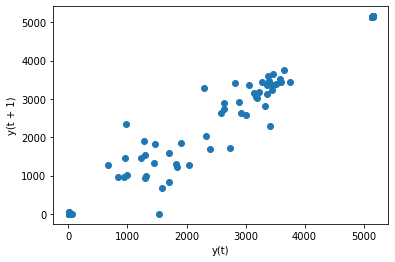

In [3]:
from pandas.plotting import lag_plot
# visulaizing the correlation in glucose
lag_plot(Glucose,lag=1)

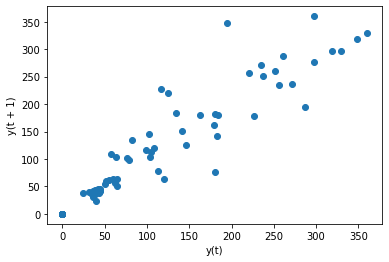

In [4]:
#visualizing in IgG
lag_plot(IgG)

# Finding the AutoCorrelation coefficient 

In [5]:
names  = ['Glucose','Glutamine','Lactate','Ammonia','TCD','VCD','IgG']
all_dfs = [Glucose,Glutamine,Lactate,Ammonia,TCD,VCD,IgG]

In [6]:
sum(Glucose.corr(method='pearson').gt(0.5).values.flatten())

10

In [7]:
sum(Glucose.corr(method='spearman').gt(0.5).values.flatten())

14

In [8]:
for name,df in zip(names,all_dfs):
    print('Pearson Correlation....')
    print(name,(sum(df.corr(method='pearson').gt(0.5).values.flatten())+sum(df.corr(method='spearman').lt(-0.5).values.flatten()))/.16)
    print('Spearman Correlation....')
    print(name,(sum(df.corr(method='spearman').gt(0.5).values.flatten())+sum(df.corr(method='spearman').lt(-0.5).values.flatten()))/.16)

Pearson Correlation....
Glucose 62.5
Spearman Correlation....
Glucose 87.5
Pearson Correlation....
Glutamine 75.0
Spearman Correlation....
Glutamine 62.5
Pearson Correlation....
Lactate 18.75
Spearman Correlation....
Lactate 18.75
Pearson Correlation....
Ammonia 56.25
Spearman Correlation....
Ammonia 56.25
Pearson Correlation....
TCD 62.5
Spearman Correlation....
TCD 62.5
Pearson Correlation....
VCD 62.5
Spearman Correlation....
VCD 62.5
Pearson Correlation....
IgG 43.75
Spearman Correlation....
IgG 56.25


# Pooled Data / 3-D Data
A combination of time-series and cross-sectional data


In [9]:
#helper function to express everythin in 3-d form
def changedf(X):
    df = X[0]
    name = X[1]
    df['Variable'] = [name]*df.shape[0]
    df['Experiment No.'] = np.array(Glucose.index)+1
    return df

new_dfs = list(map(changedf,zip(all_dfs,names)))
All_dfs = pd.concat(new_dfs).set_index(['Variable','Experiment No.'])

In [10]:
All_dfs.corr(method='pearson')

,D0,D2,D4,D7
D0,1.000000,0.935343,0.700746,0.317460
D2,0.935343,1.000000,0.873335,0.447696
D4,0.700746,0.873335,1.000000,0.699613
D7,0.317460,0.447696,0.699613,1.000000


In [11]:
All_dfs.head()

D0       D2       D4       D7
Variable Experiment No.                                   
Glucose  1               5158.0  3601.83  3186.16  2398.08
         2               5158.0  3443.21  3016.26  1704.05
         3               5158.0  3362.96  2583.66   838.86
         4               5158.0  3383.02  2643.22   976.79
         5               5158.0  3586.78  2890.87  2336.64

# Plotting the Data

In [12]:
All_dfs.loc['TCD'].head()

,D0,D2,D4,D7
Experiment No.,,,,
1,0.499,0.696,0.718,0.540
2,0.421,0.804,1.140,1.350
3,0.393,0.721,1.130,1.600
4,0.511,0.912,1.440,1.860
5,0.557,0.664,0.870,0.599


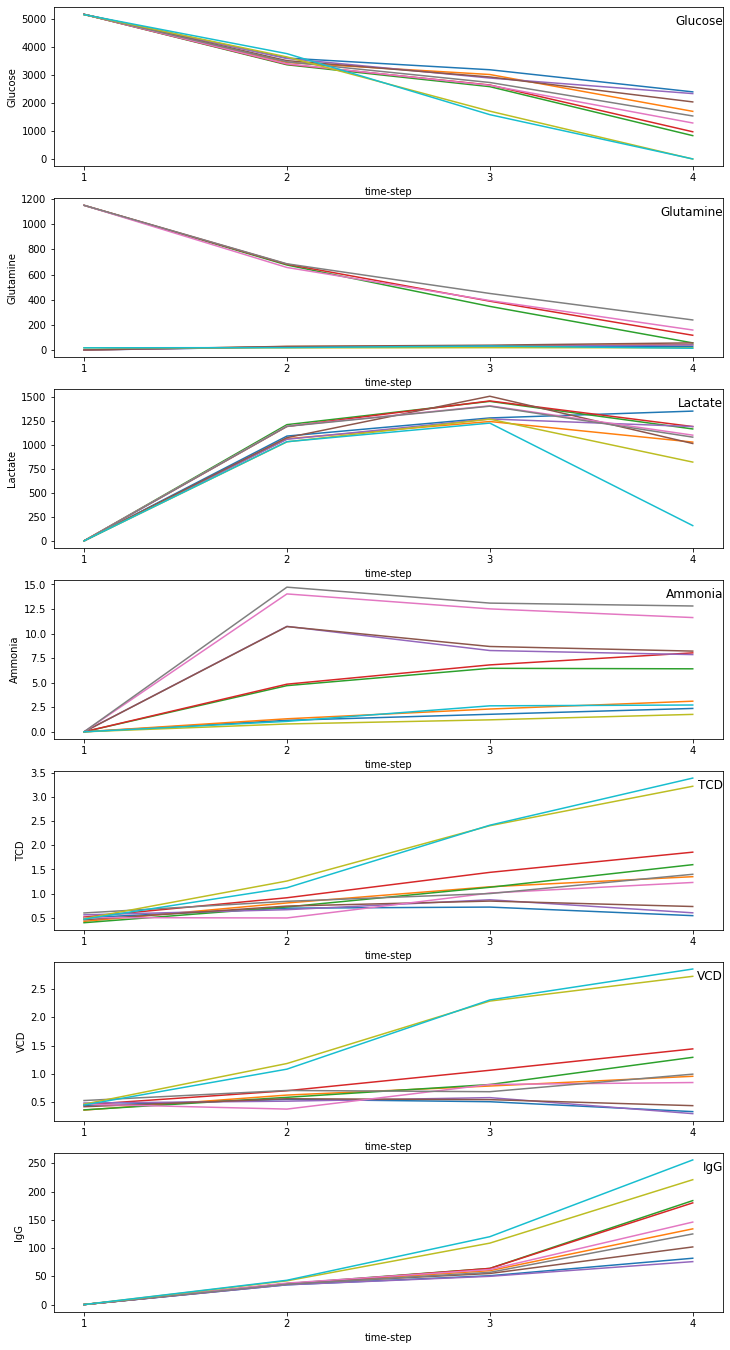

In [13]:
plt.figure(figsize=(12,24))
for idx,name in enumerate(names):
    plt.subplot(len(names),1,idx+1)
    for i in range(10):
        plt.plot(np.arange(4),All_dfs.loc[name].iloc[i].values)
        plt.xticks(np.arange(4),[1,2,3,4])
    plt.title(name,y=0.85,loc='right')
    plt.xlabel('time-step')
    plt.ylabel(name)
    

# Preparing the Data

In [14]:
def dropcolumns(df):
    return df.drop(['Variable', 'Experiment No.','D7'],axis=1).astype(float)

train_df = pd.concat(list(map(dropcolumns,all_dfs)),axis=1)

In [28]:
from sklearn.preprocessing import MinMaxScaler
scalertrain = MinMaxScaler()
normalized = scalertrain.fit_transform(train_df.values)
X = normalized.reshape((Glucose.shape[0],3,len(all_dfs)),order='F')

In [50]:
def D7column(df):
    return df['D7']

#test_df = pd.concat(list(map(D7column,all_dfs)),axis=1)
test_df = D7column(all_dfs[-1])
scalertest = MinMaxScaler()
normtest = scalertest.fit_transform(test_df.values.reshape(24,1))
y = normtest

In [87]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.2,random_state=47)

# Building the model

In [88]:
import tensorflow as tf

In [89]:
# Online Learning batch size 1, time-step 3- predicting 1 

n_batch = 1
n_epoch = [100,200]
n_neurons = 4
ypred = []

for e in n_epoch:

    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.LSTM(n_neurons, batch_input_shape=(n_batch, X.shape[1], X.shape[2]),
                   stateful=True))
    model.add(tf.keras.layers.Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(X_train,y_train,epochs=e,
              batch_size=n_batch,shuffle=False,verbose = 0)
    yhat = model.predict(X_test)
    ypred.append(yhat)

# Mean Squared Error

In [90]:
mean_squared_error(y_test,ypred[0])

0.01264979977390831

In [91]:
mean_squared_error(y_test,ypred[1])

0.004734544941074946

# Inverse transform the values

In [82]:
from sklearn.metrics import mean_squared_error

In [83]:
mean_squared_error(y_test,ypred[1])

0.002586034398739731

In [84]:
scalertest.inverse_transform(y_test)

array([[102.  ],
       [297.  ],
       [256.  ],
       [297.23],
       [ 82.  ]])

In [85]:
scalertest.inverse_transform(ypred[0])

array([[139.38942 ],
       [314.6001  ],
       [229.65378 ],
       [330.1704  ],
       [104.016426]], dtype=float32)

In [86]:
scalertest.inverse_transform(ypred[1])

array([[105.5706 ],
       [298.18546],
       [269.61493],
       [312.71912],
       [106.56546]], dtype=float32)

# Working with the difference 

In [98]:
def newdf(df):
    return dropcolumns(df).diff(axis=1).dropna(axis=1)

train_newdf = pd.concat(list(map(newdf,all_dfs)),axis=1)

In [100]:
train_newdf.head()

,D2,D4,D2,D4,D2,D4,D2,D4,D2,D4,D2,D4,D2,D4
0,-1556.17,-415.67,24.14,1.21,1094.27,189.30,1.170,0.612,0.197,0.022,0.107,-0.042,35.0,16.0
1,-1714.79,-426.95,27.04,5.79,1066.68,179.71,1.325,0.994,0.383,0.336,0.267,0.161,37.0,23.0
2,-1795.04,-779.30,-474.03,-328.57,1213.57,243.08,4.700,1.764,0.328,0.409,0.223,0.228,37.0,27.0
3,-1774.98,-739.80,-467.27,-294.05,1194.28,266.99,4.849,1.964,0.401,0.528,0.248,0.364,36.0,28.0
4,-1571.22,-695.91,23.90,2.90,1060.47,212.50,10.735,-2.460,0.107,0.206,0.033,0.063,35.0,15.0


In [101]:
scalernewtrain = MinMaxScaler()
normalizednew = scalertrain.fit_transform(train_newdf.values)
Xnew = normalizednew.reshape((Glucose.shape[0],2,len(all_dfs)),order='F')

In [121]:
indices = np.arange(0,24)

In [122]:
indices

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23])

In [123]:
X_newtrain,X_newtest,y_trainnew,y_testnew,idx1,idx2 = train_test_split(Xnew,y,indices,test_size = 0.2,random_state=47)

In [124]:
idx2

array([ 5, 22,  9, 19,  0])

In [103]:
n_batch = 1
n_epoch = [100,200]
n_neurons = 4
yprednew = []

for e in n_epoch:

    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.LSTM(n_neurons, batch_input_shape=(n_batch, Xnew.shape[1], Xnew.shape[2]),
                   stateful=True))
    model.add(tf.keras.layers.Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(X_newtrain,y_train,epochs=e,
              batch_size=n_batch,shuffle=False,verbose = 0)
    yhat = model.predict(X_newtest)
    yprednew.append(yhat)

In [106]:
mean_squared_error(y_test,yprednew[0])

0.023195333565865336

In [107]:
mean_squared_error(y_test,yprednew[1])

0.005796230339786311

In [114]:
scalertest.inverse_transform(y_test)

array([[102.  ],
       [297.  ],
       [256.  ],
       [297.23],
       [ 82.  ]])

In [115]:
scalertest.inverse_transform(yprednew[1])

array([[117.61862],
       [297.12784],
       [249.77011],
       [300.2446 ],
       [127.22883]], dtype=float32)

In [150]:
scalertest.inverse_transform(ypred[1])

array([[ 86.467316],
       [280.1586  ],
       [262.57635 ],
       [291.35745 ],
       [118.14851 ]], dtype=float32)

# Antibody Concentration Profile Final Day Prediction with difference of columns

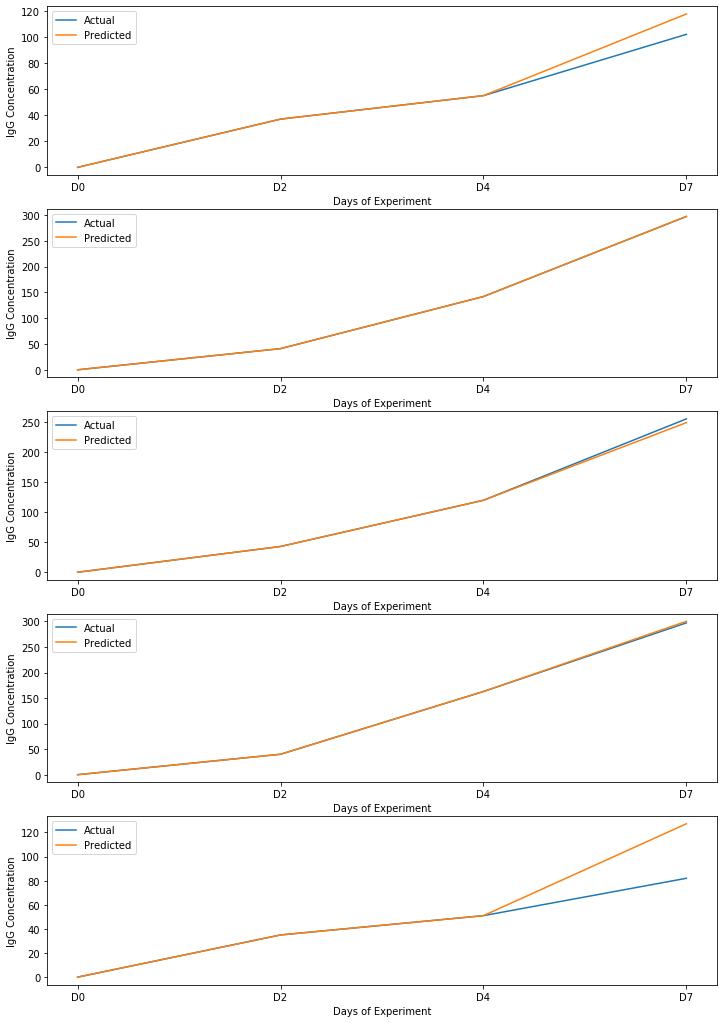

In [297]:
plt.figure(figsize=(12,18))
for i in range(5):
    plt.subplot(5,1,i+1)
    plt.plot(np.arange(4),IgG.loc[:,['D0','D2','D4','D7']].iloc[idx2[i]].values,label='Actual')
    plt.plot(np.arange(4),np.append(IgG.loc[:,['D0','D2','D4']].iloc[idx2[i]].values,
                                    scalertest.inverse_transform(yprednew[1])[i]),label='Predicted')
    plt.xticks(np.arange(4),['D0','D2','D4','D7'])
    plt.xlabel('Days of Experiment')
    plt.ylabel('IgG Concentration')
    plt.legend()
#    plt.savefig('AntibodyConcFinalDayPrediction.png')

# Antibody Concentration Profile Final Day Prediction without difference of columns

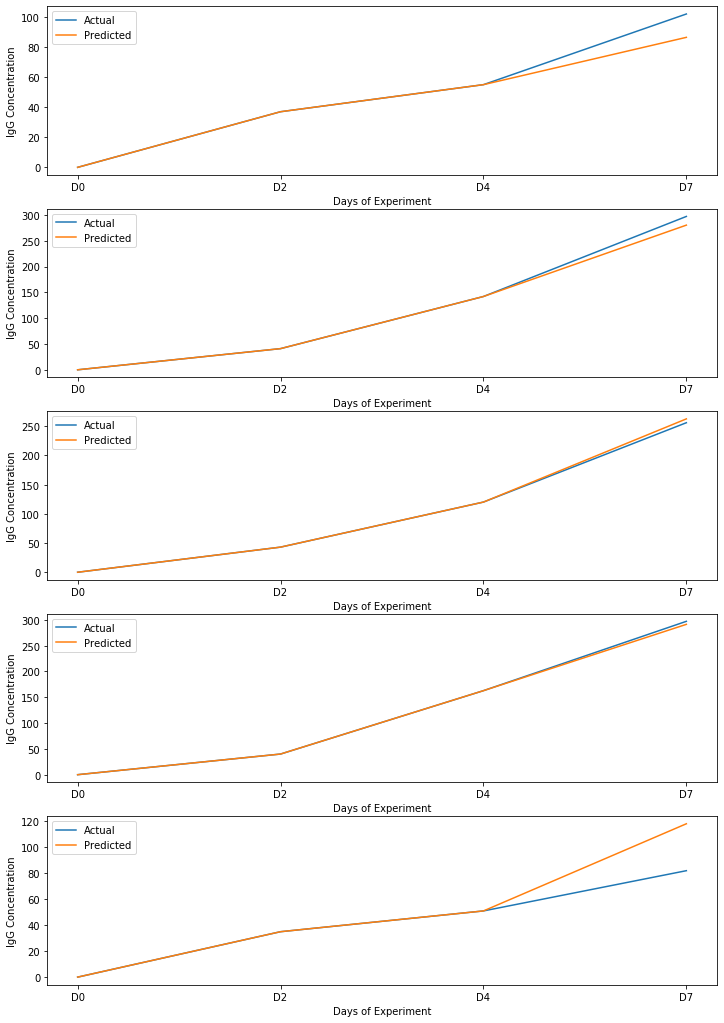

In [298]:
plt.figure(figsize=(12,18))
for i in range(5):
    plt.subplot(5,1,i+1)
    plt.plot(np.arange(4),IgG.loc[:,['D0','D2','D4','D7']].iloc[idx2[i]].values,label='Actual')
    plt.plot(np.arange(4),np.append(IgG.loc[:,['D0','D2','D4']].iloc[idx2[i]].values,
                                    scalertest.inverse_transform(ypred[1])[i]),label='Predicted')
    plt.xticks(np.arange(4),['D0','D2','D4','D7'])
    plt.legend()
    plt.xlabel('Days of Experiment')
    plt.ylabel('IgG Concentration')
#    plt.savefig('AntibodyConcFinalDayPrediction2.png')

# Continuous Antibody Prediction

## Preparing data

In [203]:
def D4column(df):
    return df.loc[:,'D4']

test_df2 = D7column(all_dfs[-1])
test_df1 = D4column(all_dfs[-1])

test_df  = pd.concat([test_df1,test_df2],axis=1)
scalertest1 = MinMaxScaler()
scalertest2 = MinMaxScaler()
y1 = scalertest1.fit_transform(test_df1.values.reshape(24,1))
y2 = scalertest2.fit_transform(test_df2.values.reshape(24,1))

In [212]:
def dropcolumnsD7(df):
    return df.drop(['D0','Variable', 'Experiment No.','D7'],axis=1).astype(float)

def dropcolumnsD4(df):
    return df.drop(['D4','Variable', 'Experiment No.','D7'],axis=1).astype(float)

train_df2 = pd.concat(list(map(dropcolumnsD7,all_dfs)),axis=1)
train_df1 = pd.concat(list(map(dropcolumnsD4,all_dfs)),axis=1)

In [213]:
scalertrain1 = MinMaxScaler()
scalertrain2 = MinMaxScaler()
normalized1 = scalertrain1.fit_transform(train_df1.values)
normalized2 = scalertrain2.fit_transform(train_df2.values)
X1 = normalized1.reshape((Glucose.shape[0],2,len(all_dfs)),order='F')
X2 = normalized2.reshape((Glucose.shape[0],2,len(all_dfs)),order='F')

In [233]:
X_train1,X_test1,y_train1,y_test1,idx11,idx12 = train_test_split(X1,y1,indices,test_size = 0.2,random_state=47)
X_train2,X_test2,y_train2,y_test2,idx21,idx22 = train_test_split(X2,y2,indices,test_size = 0.2,random_state=47)

In [217]:
Xtrain = [X_train1,X_train2]
Xtest = [X_test1,X_test2]
ytrain = [y_train1,y_train2]
ytest = [y_test1,y_test2]

In [218]:
class AntibodyPredict:
    
    def __init__(self,Xtrain,ytrain,Xtest=None,ytest=None):
        self.Xtrain = Xtrain
        self.ytrain = ytrain
        self.Xtest = Xtest
        self.ytest = ytest
        
    def train(self,epoch,neurons):
        self.model = tf.keras.models.Sequential()
        self.model.add(tf.keras.layers.LSTM(neurons, batch_input_shape=(n_batch, self.Xtrain.shape[1], self.Xtrain.shape[2]),
                       stateful=True))
        self.model.add(tf.keras.layers.Dense(1))
        self.model.compile(loss='mean_squared_error', optimizer='adam')
        self.model.fit(self.Xtrain,self.ytrain,epochs=epoch,
                  batch_size=1,shuffle=False,verbose = 0)
        return self
    
    def predict(self):
        return self.model.predict(self.Xtest)
    
    def loss_on_prediction(self):
        return mean_squared_error(self.ytest,self.predict())       
        
        

In [301]:
class Experiment:
    
    def __init__(self,timestep,Xtrain,ytrain,Xtest=None,ytest=None):
        self.timestep=timestep
        self.Xtrain = Xtrain
        self.ytrain = ytrain
        self.Xtest = Xtest
        self.ytest = ytest
        
    def multiTrain(self,neurons,epoch):
        self.model = tf.keras.models.Sequential()
        self.model.add(tf.keras.layers.LSTM(neurons, batch_input_shape=(n_batch, self.Xtrain[0].shape[1], self.Xtrain[0].shape[2]),stateful=True))
        self.model.add(tf.keras.layers.Dense(1))
        self.model.compile(loss='mean_squared_error', optimizer='adam')                   
        for t in range(self.timestep):
            self.model.fit(self.Xtrain[t],self.ytrain[t],epochs=epoch,
                      batch_size=1,shuffle=False,verbose = 0)
            #self.model.reset_states()
        return self
    
    def predictOneStep(self):
        predictions = []
        for t in range(self.timestep):
            predictions.append(self.model.predict(Xtest[t]))
        return predictions
            
    def predictMultiStep(self):
        # not possible right now without more data
        pass
    
    def multiTrainPredict(self,neurons,epoch):
        predictions = []
        self.model = tf.keras.models.Sequential()
        self.model.add(tf.keras.layers.LSTM(neurons, batch_input_shape=(n_batch, self.Xtrain[0].shape[1], self.Xtrain[0].shape[2]),stateful=True))
        self.model.add(tf.keras.layers.Dense(1))
        self.model.compile(loss='mean_squared_error', optimizer='adam')                   
        for t in range(self.timestep):
            self.model.fit(self.Xtrain[t],self.ytrain[t],epochs=epoch,
                      batch_size=1,shuffle=False,verbose = 0)
            predictions.append(self.model.predict(Xtest[t]))
            self.model.reset_states()
        return predictions   

In [290]:
Exp1 = Experiment(2,Xtrain,ytrain,Xtest,ytest)

In [291]:
yhat = Exp1.multiTrainPredict(10,400)

In [292]:
scalertest1.inverse_transform(yhat[0])

array([[ 55.793587],
       [112.84868 ],
       [135.28314 ],
       [136.37834 ],
       [106.13326 ]], dtype=float32)

In [293]:
scalertest1.inverse_transform(ytest[0])

array([[ 55.  ],
       [141.95],
       [120.14],
       [162.84],
       [ 51.  ]])

In [294]:
scalertest2.inverse_transform(ytest[1])

array([[102.  ],
       [297.  ],
       [256.  ],
       [297.23],
       [ 82.  ]])

In [295]:
scalertest2.inverse_transform(yhat[1])

array([[110.66821],
       [300.28632],
       [264.44693],
       [278.13345],
       [137.25197]], dtype=float32)

In [237]:
idx2

array([ 5, 22,  9, 19,  0])

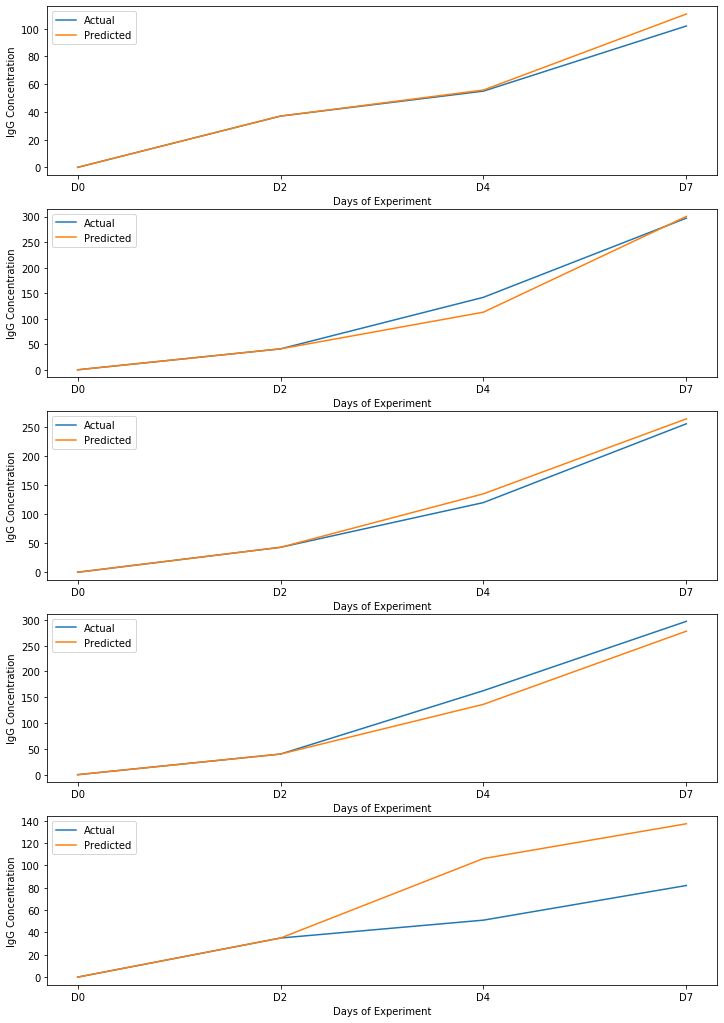

In [302]:
plt.figure(figsize=(12,18))
for i in range(5):
    plt.subplot(5,1,i+1)
    plt.plot(np.arange(4),IgG.loc[:,['D0','D2','D4','D7']].iloc[idx2[i]].values,label='Actual')
    plt.plot(np.arange(4),np.append(IgG.loc[:,['D0','D2']].iloc[idx2[i]].values,
                                    [scalertest1.inverse_transform(yhat[0])[i],scalertest2.inverse_transform(yhat[1])[i]]),label='Predicted')
    plt.xticks(np.arange(4),['D0','D2','D4','D7'])
    plt.xlabel('Days of Experiment')
    plt.ylabel('IgG Concentration')
    plt.legend()
#    plt.savefig('AntibodyConcContPred.png')